# CS3244 Project Decision Tree Classifier

# Importing datasets and packages

We will begin with importing all relevant datasets and packages needed in order to create our model.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFECV, mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import optuna

/Users/joanwong/Desktop/cs3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Users/joanwong/Desktop/cs3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#load smote_train_data for training data and transformed_data for evaluation
smote_train_data_folder_path = '/finalised_datasets/smote_train_data'
transformed_data_folder_path = '/finalised_datasets/transformed_data'

smote_files = ['smote_fold_1.csv', 'smote_fold_2.csv', 'smote_fold_3.csv', 'smote_fold_4.csv', 'smote_fold_5.csv']
non_smote_files = ['fold_1.csv', 'fold_2.csv','fold_3.csv', 'fold_4.csv', 'fold_5.csv']


testing_data = pd.read_csv('/transformed_data/test_set.csv')
testing_data = testing_data.drop(columns = ['client_id', 'creation_date'])


# Feature Selection

##  Recursive Feature Elimination with Cross-Validation (RFECV)

In [3]:
# Custom cross-validation using RFECV
feature_rankings = pd.DataFrame()  # Track feature rankings across all folds

for i in range(len(smote_files)):
    # Define training and testing sets
    train_smote_files = [file for j, file in enumerate(smote_files) if j != i]  # All folds except the i-th for training
    test_non_smote_file = non_smote_files[i]  # The corresponding non-smoted fold for testing

    # Load training data
    train_dataframes = []
    for file in train_smote_files:
        file_path = os.path.join(smote_train_data_folder_path, file)
        df = pd.read_csv(file_path)
        train_dataframes.append(df)

    # Concatenate training data
    train_data = pd.concat(train_dataframes, ignore_index=True)

    # Load testing data
    test_file_path = os.path.join(smote_train_data_folder_path, test_non_smote_file)
    test_data = pd.read_csv(test_file_path)

    # Split features and target
    features = train_data.columns.drop('fraud_status')
    X_train = train_data[features]
    y_train = train_data['fraud_status']
    X_test = test_data[features]
    y_test = test_data['fraud_status']

    # Feature Selection using RFECV
    print(f"\nFold {i+1}: Performing RFECV for feature selection...")
    model = DecisionTreeClassifier(random_state=42)
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # 3-fold cross-validation within each fold
    rfecv = RFECV(estimator=model, step=2, cv=cv, scoring='f1', n_jobs=-1)
    rfecv.fit(X_train, y_train)
 
    # Store feature rankings
    ranking = pd.Series(rfecv.ranking_, index=features)
    feature_rankings = pd.concat([feature_rankings, ranking], axis=1)

    # Train model with selected features (RFECV)
    selected_features_rfecv = X_train.columns[rfecv.support_]
    X_train_rfecv = X_train[selected_features_rfecv]
    X_test_rfecv = X_test[selected_features_rfecv]
    model.fit(X_train_rfecv, y_train)
    y_pred_rfecv = model.predict(X_test_rfecv)
    f1_rfecv = f1_score(y_test, y_pred_rfecv)
    print(f"RFECV Fold {i+1}: F1 Score = {f1_rfecv:.4f}")



Fold 1: Performing RFECV for feature selection...
RFECV Fold 1: F1 Score = 0.0000

Fold 2: Performing RFECV for feature selection...
RFECV Fold 2: F1 Score = 0.2187

Fold 3: Performing RFECV for feature selection...
RFECV Fold 3: F1 Score = 0.0017

Fold 4: Performing RFECV for feature selection...
RFECV Fold 4: F1 Score = 0.2466

Fold 5: Performing RFECV for feature selection...
RFECV Fold 5: F1 Score = 0.2501


### Selecting an Optimal Number of Features
Choosing the number of features based on when the graph of Number of Features Used vs Cross Validation (F1 Score) reaches a plateau.
Ranking of features is aggregated across the 5 folds.

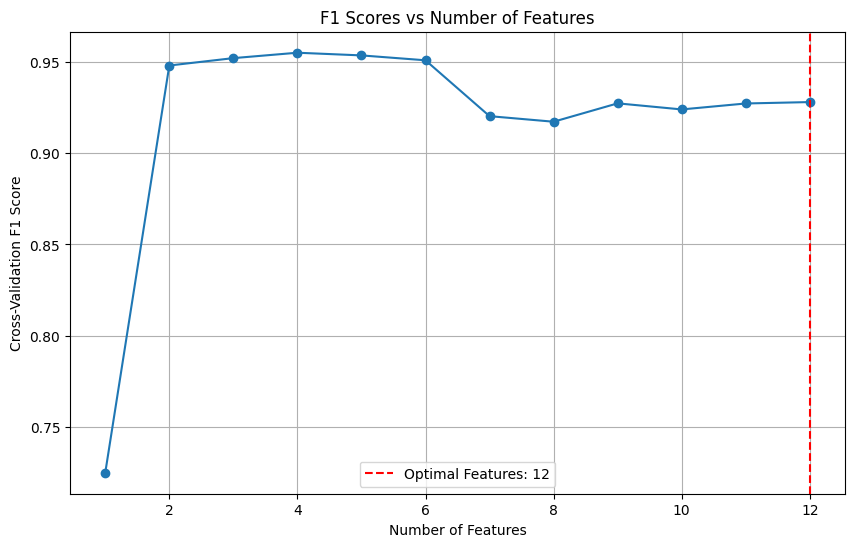

Optimal number of features where change is sufficiently close to 0: 12
Selected features based on optimal number: ['meter_number_count', 'reading_remark_8', 'meter_code_count', 'months_number_max', 'district_63', 'district_69', 'old_index_median', 'region_101', 'district_62', 'consumption_level_2_max', 'meter_status_1.0', 'old_index_mean']


In [4]:
# Aggregate feature rankings across all folds
avg_rankings = feature_rankings.mean(axis=1)
sorted_features = avg_rankings.sort_values().index  # Features sorted by average rank

# Code for plotting F1 scores vs number of features and determining optimal count
f1_scores = []
threshold = 0.001  # Set a threshold 
last_f1_score = None
optimal_num_features = None

# Loop through increasing numbers of features
for i in range(1, len(sorted_features) + 1):
    selected_features = sorted_features[:i]
    X_train_selected = X_train[selected_features]
    
    # Perform cross-validation with the selected features
    model = DecisionTreeClassifier(random_state=42)
    f1 = cross_val_score(model, X_train_selected, y_train, cv=3, scoring='f1').mean()
    f1_scores.append(f1)

    # Check if the difference is sufficiently small
    if last_f1_score is not None:
        difference = abs(f1 - last_f1_score)
        if difference <= threshold:
            optimal_num_features = i
            break

    last_f1_score = f1

# Plot the F1 scores vs number of features (show the entire range)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(f1_scores) + 1), f1_scores, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Cross-Validation F1 Score')
plt.title('F1 Scores vs Number of Features')
plt.grid()

# Mark the optimal number of features
if optimal_num_features is not None:
    plt.axvline(x=optimal_num_features, color='r', linestyle='--', label=f'Optimal Features: {optimal_num_features}')
plt.legend()
plt.show()

# Print the optimal number of features and the selected features
if optimal_num_features is not None:
    print(f"Optimal number of features where change is sufficiently close to 0: {optimal_num_features}")
    selected_features_final = sorted_features[:optimal_num_features]
    print(f"Selected features based on optimal number: {list(selected_features_final)}")
else:
    print("No plateau detected within the set threshold.")

selected_features_rfecv = list(selected_features_final)

## Mutual Information

Fold 1: Performing Mutual Information for feature selection...
Optimal number of features based on cross-validation for Fold 1: 1
Selected features using Mutual Information: Index(['is_index_discrepancy_False'], dtype='object')


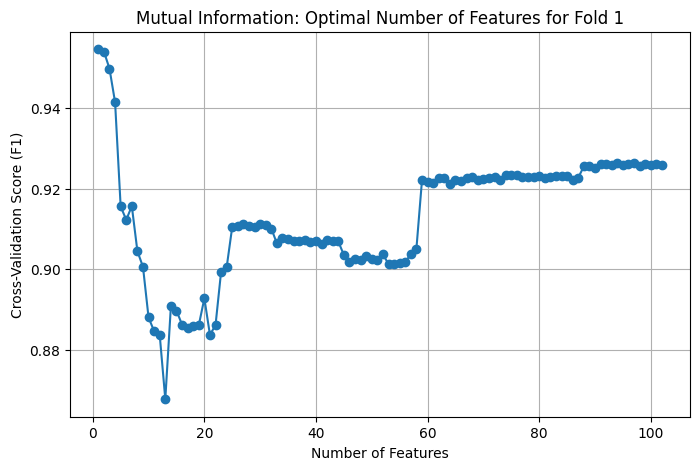

Mutual Information Fold 1: F1 Score = 0.0099
Fold 2: Performing Mutual Information for feature selection...
Optimal number of features based on cross-validation for Fold 2: 1
Selected features using Mutual Information: Index(['is_index_discrepancy_False'], dtype='object')


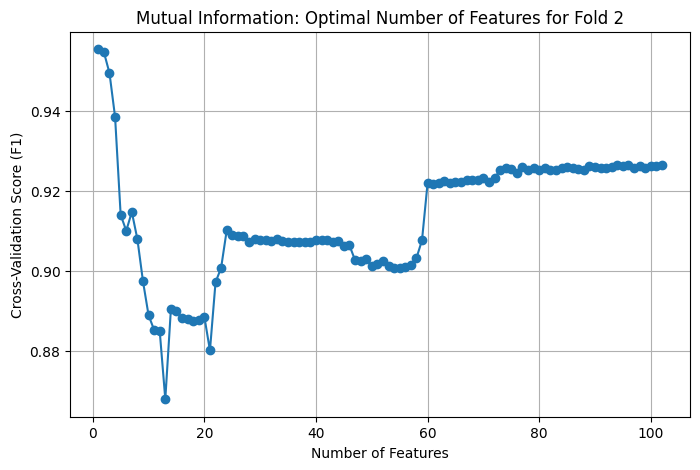

Mutual Information Fold 2: F1 Score = 0.0066
Fold 3: Performing Mutual Information for feature selection...
Optimal number of features based on cross-validation for Fold 3: 1
Selected features using Mutual Information: Index(['no_of_invoices'], dtype='object')


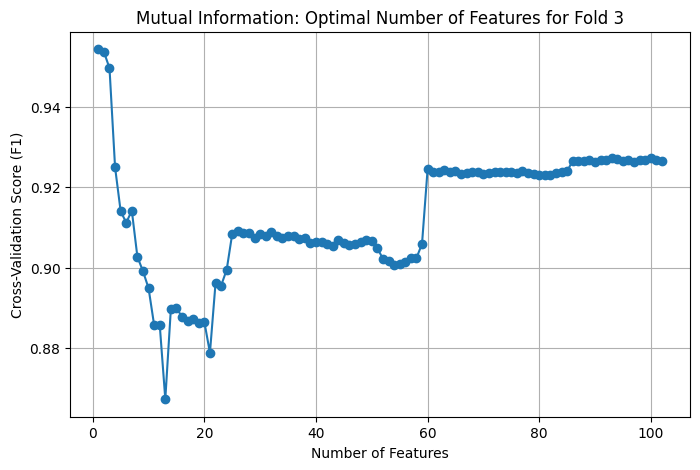

Mutual Information Fold 3: F1 Score = 0.0017
Fold 4: Performing Mutual Information for feature selection...
Optimal number of features based on cross-validation for Fold 4: 1
Selected features using Mutual Information: Index(['no_of_invoices'], dtype='object')


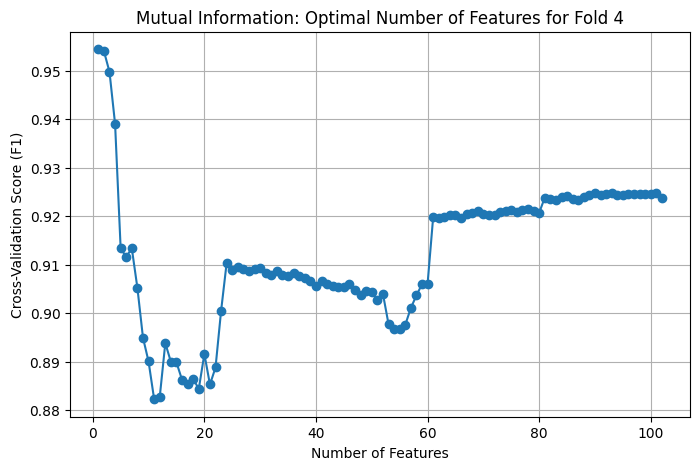

Mutual Information Fold 4: F1 Score = 0.0131
Fold 5: Performing Mutual Information for feature selection...
Optimal number of features based on cross-validation for Fold 5: 1
Selected features using Mutual Information: Index(['is_index_discrepancy_False'], dtype='object')


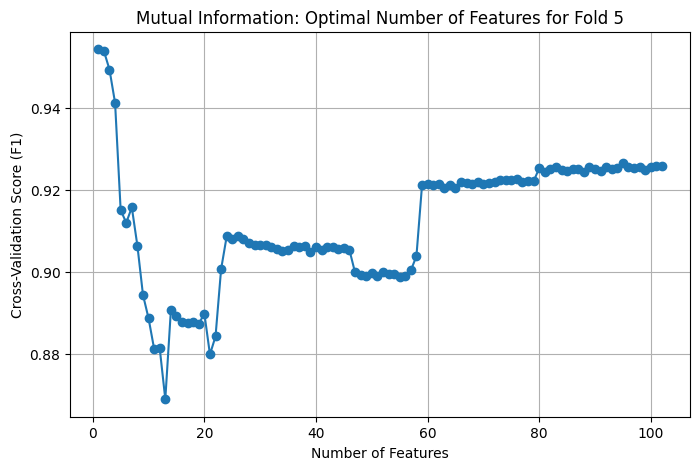

Mutual Information Fold 5: F1 Score = 0.0033


In [5]:
# Custom cross-validation using Mutual Information
feature_counts_mi = []  # Track number of features selected for each fold
selected_features_mi_all_folds = []  # Track selected features for each fold
avg_mutual_info = pd.DataFrame()  # Track feature importance values across all folds

for i in range(len(smote_files)):
    # Define training and testing sets
    train_smote_files = [file for j, file in enumerate(smote_files) if j != i]  # All folds except the i-th for training
    test_non_smote_file = non_smote_files[i]  # The corresponding non-smoted fold for testing

    # Load training data
    train_dataframes = []
    for file in train_smote_files:
        file_path = os.path.join(smote_train_data_folder_path, file)
        df = pd.read_csv(file_path)
        train_dataframes.append(df)

    # Concatenate training data
    train_data = pd.concat(train_dataframes, ignore_index=True)

    # Load testing data
    test_file_path = os.path.join(smote_train_data_folder_path, test_non_smote_file)
    test_data = pd.read_csv(test_file_path)

    # Split features and target
    features = train_data.columns.drop('fraud_status')
    X_train = train_data[features]
    y_train = train_data['fraud_status']
    X_test = test_data[features]
    y_test = test_data['fraud_status']

    # Feature Selection using Mutual Information
    print(f"Fold {i+1}: Performing Mutual Information for feature selection...")
    mutual_info = mutual_info_classif(X_train, y_train)
    mutual_info_series = pd.Series(mutual_info, index=X_train.columns).sort_values(ascending=False)
    avg_mutual_info = pd.concat([avg_mutual_info, mutual_info_series], axis=1)  # Store feature importance

    scores = []

    # Determine optimal number of features using cross-validation
    best_score = 0
    optimal_k = 0
    for k in range(1, len(mutual_info_series) + 1):
        selected_features = mutual_info_series.head(k).index
        X_train_selected = X_train[selected_features]
        score = cross_val_score(model, X_train_selected, y_train, cv=3, scoring='f1').mean()
        scores.append(score)

        if score > best_score:
            best_score = score
            optimal_k = k

    print(f"Optimal number of features based on cross-validation for Fold {i + 1}: {optimal_k}")
    selected_features_mi_optimal = mutual_info_series.head(optimal_k).index
    print("Selected features using Mutual Information:", selected_features_mi_optimal)
    feature_counts_mi.append(len(selected_features_mi_optimal))
    selected_features_mi_all_folds.append(selected_features_mi_optimal)

    # Plot the cross-validation scores vs. number of features
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(mutual_info_series) + 1), scores, marker='o')
    plt.xlabel('Number of Features')
    plt.ylabel('Cross-Validation Score (F1)')
    plt.title(f'Mutual Information: Optimal Number of Features for Fold {i + 1}')
    plt.grid(True)
    plt.show()

    X_train_mi = X_train[selected_features_mi_optimal]
    X_test_mi = X_test[selected_features_mi_optimal]

    # Step 2: Train model with selected features (Mutual Information)
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train_mi, y_train)
    y_pred_mi = model.predict(X_test_mi)
    f1_mi = f1_score(y_test, y_pred_mi)
    print(f"Mutual Information Fold {i+1}: F1 Score = {f1_mi:.4f}")



### Selecting an Optimal Number of Features
Choosing the number of features based on when the graph of Number of Features Used vs Cross Validation (F1 Score) reaches a plateau.
Ranking of features is aggregated across the 5 folds.


Aggregated Feature Importance (Mean Mutual Information Scores):
is_index_discrepancy_False     0.549419
no_of_invoices                 0.548631
meter_type_0                   0.535211
reading_remark_6               0.530398
time_since_last_invoice_max    0.528949
                                 ...   
meter_coefficient_50           0.000193
region_399                     0.000192
region_199                     0.000136
meter_status_3.0               0.000029
meter_coefficient_10           0.000016
Length: 102, dtype: float64


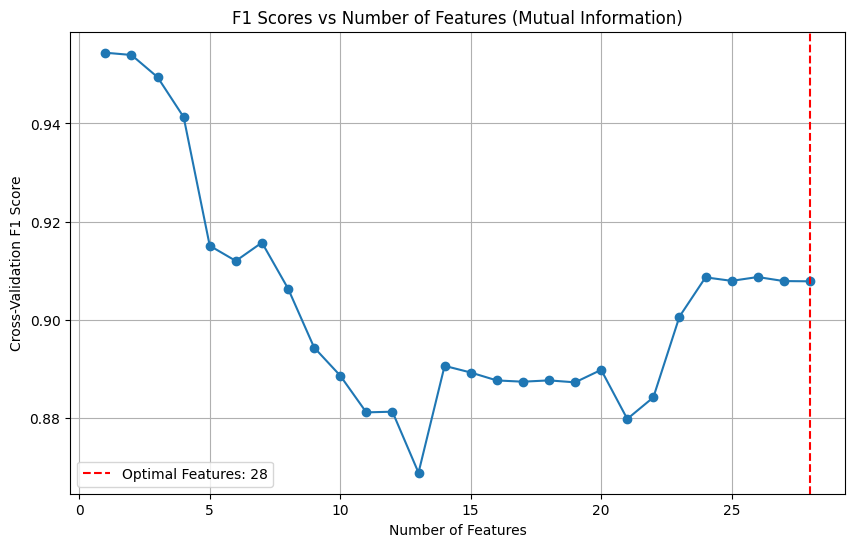


Optimal number of features where change is sufficiently close to 0: 28
Selected features based on optimal number: ['is_index_discrepancy_False', 'no_of_invoices', 'meter_type_0', 'reading_remark_6', 'time_since_last_invoice_max', 'reading_remark_9', 'reading_remark_8', 'time_since_last_invoice_min', 'time_since_last_invoice_median', 'consumption_level_1_max', 'total_consumption_max', 'diff_in_index_max', 'consumption_level_2_max', 'months_number_max', 'meter_type_1', 'consumption_level_1_min', 'consumption_level_2_sum', 'total_consumption_min', 'diff_in_index_min', 'meter_number_count', 'consumption_level_3_max', 'meter_status_1.0', 'meter_code_count', 'months_number_min', 'consumption_level_3_sum', 'time_since_last_invoice_mean', 'consumption_level_2_mean', 'consumption_level_1_sum']


In [6]:
# Aggregated Feature Importance
avg_mutual_info_mean = avg_mutual_info.mean(axis=1).sort_values(ascending=False)  # Mean importance across all folds
print("\nAggregated Feature Importance (Mean Mutual Information Scores):")
print(avg_mutual_info_mean)

# Determine Optimal Features across all folds based on average mutual information
f1_scores = []
threshold = 0.0001  # Set a threshold
last_f1_score = None
optimal_num_features = None

# Loop through increasing numbers of features based on average mutual information ranking
for i in range(1, len(avg_mutual_info_mean) + 1):
    selected_features = avg_mutual_info_mean.head(i).index
    X_train_selected = X_train[selected_features]
    
    # Perform cross-validation with the selected features
    model = DecisionTreeClassifier(random_state=42)
    f1 = cross_val_score(model, X_train_selected, y_train, cv=3, scoring='f1').mean()
    f1_scores.append(f1)

    # Check if the difference is sufficiently small
    if last_f1_score is not None:
        difference = abs(f1 - last_f1_score)
        if difference <= threshold:
            optimal_num_features = i
            break

    last_f1_score = f1

# Plot the F1 scores vs number of features
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(f1_scores) + 1), f1_scores, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Cross-Validation F1 Score')
plt.title('F1 Scores vs Number of Features (Mutual Information)')
plt.grid()

# Mark the optimal number of features 
if optimal_num_features is not None:
    plt.axvline(x=optimal_num_features, color='r', linestyle='--', label=f'Optimal Features: {optimal_num_features}')
plt.legend()
plt.show()

# Print the optimal number of features and the selected features
if optimal_num_features is not None:
    print(f"\nOptimal number of features where change is sufficiently close to 0: {optimal_num_features}")
    selected_features_final = avg_mutual_info_mean.head(optimal_num_features).index
    print(f"Selected features based on optimal number: {list(selected_features_final)}")
else:
    print("\nNo plateau detected within the set threshold.")

selected_features_mi = list(selected_features_final)

# Methods Selection

In [7]:
# Load the complete training and testing datasets
train_data = pd.concat([pd.read_csv(os.path.join(smote_train_data_folder_path, file)) for file in smote_files], ignore_index=True)
test_data = pd.read_csv(os.path.join(transformed_data_folder_path, 'test_set.csv'))

# Split features and target for training and testing
features = train_data.columns.drop('fraud_status')
X_train_full = train_data[features]
y_train_full = train_data['fraud_status']
X_test_full = test_data[features]
y_test_full = test_data['fraud_status']


# Create a sample with a stratified split to maintain class balance
sample_fraction = 0.4
X_sample, X_sample_test, y_sample, y_sample_test = train_test_split(X_train_full, y_train_full, test_size=(1 - sample_fraction), stratify=y_train_full, random_state=42)

# Choosing Between Feature Selection Methods

In [8]:
# Use Optuna to choose the best feature selection method (RFECV or Mutual Information)
def feature_selection_objective(trial):
    feature_method = trial.suggest_categorical('feature_method', ['RFECV', 'Mutual Information'])
    
    # Use the sample dataset for training and testing
    if feature_method == 'RFECV':
        features = selected_features_rfecv
    else:
        features = selected_features_mi_optimal

    X_train = X_sample[features]
    y_train = y_sample
    X_test_final_selected = X_sample_test[features]
    y_test_final = y_sample_test

    # Train and evaluate model
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test_final_selected)
    f1 = f1_score(y_test_final, y_pred)

    return f1

# Run Optuna to find the best feature selection method
feature_study = optuna.create_study(direction='maximize')
feature_study.optimize(feature_selection_objective, n_trials=30)

best_feature_method = feature_study.best_trial.params['feature_method']
print("Best feature selection method:", best_feature_method)
print("Best F1 score:", feature_study.best_value)

[I 2024-11-30 14:50:46,844] A new study created in memory with name: no-name-3dbfe34b-1b53-4348-874e-ef32a1039689
[I 2024-11-30 14:50:47,455] Trial 0 finished with value: 0.934376597972452 and parameters: {'feature_method': 'RFECV'}. Best is trial 0 with value: 0.934376597972452.
[I 2024-11-30 14:50:48,282] Trial 1 finished with value: 0.9542359192348565 and parameters: {'feature_method': 'Mutual Information'}. Best is trial 1 with value: 0.9542359192348565.
[I 2024-11-30 14:50:48,851] Trial 2 finished with value: 0.934376597972452 and parameters: {'feature_method': 'RFECV'}. Best is trial 1 with value: 0.9542359192348565.
[I 2024-11-30 14:50:49,672] Trial 3 finished with value: 0.9542359192348565 and parameters: {'feature_method': 'Mutual Information'}. Best is trial 1 with value: 0.9542359192348565.
[I 2024-11-30 14:50:50,500] Trial 4 finished with value: 0.9542359192348565 and parameters: {'feature_method': 'Mutual Information'}. Best is trial 1 with value: 0.9542359192348565.
[I 20

Best feature selection method: Mutual Information
Best F1 score: 0.9542359192348565


# Hyperparameter Tuning & Choosing Best Ensemble Model with Optuna

In [9]:
param_grids = {
    'Bagging': {
        'n_estimators': [10, 50, 100],
        'max_samples': [0.5, 0.7, 1.0],
    },
    'RandomForest': {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20, 30],
    },
    'AdaBoost': {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 1],
    },
    'XGBoost': {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 6, 9],
    },
    'LightGBM': {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 0.2],
        'num_leaves': [31, 50, 100],
    }
}

In [10]:
# : Use Optuna to choose the best ensemble model (Bagging/Random Forest/XGBoost/AdaBoost/LightGBM)
def model_selection_objective(trial):
    # Use the best feature selection method 
    features = selected_features_rfecv if best_feature_method == 'RFECV' else selected_features_mi_optimal

    X_train = X_sample[features]
    y_train = y_sample
    X_test_final_selected = X_sample_test[features]
    y_test_final = y_sample_test

    # Choose the ensemble model type and hyperparameters
    model_name = trial.suggest_categorical('model_name', ['Bagging', 'RandomForest', 'AdaBoost', 'XGBoost', 'LightGBM'])
    
    if model_name == 'Bagging':
        n_estimators = trial.suggest_int('n_estimators', 10, 100, step=10)
        max_samples = trial.suggest_float('max_samples', 0.5, 1.0, step=0.1)
        model = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=n_estimators, max_samples=max_samples, random_state=42)
    elif model_name == 'RandomForest':
        n_estimators = trial.suggest_int('n_estimators', 50, 150, step=50)
        max_depth = trial.suggest_int('max_depth', 10, 30, step=10)
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    elif model_name == 'AdaBoost':
        n_estimators = trial.suggest_int('n_estimators', 50, 150, step=50)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 1.0, log=True)
        model = AdaBoostClassifier(estimator=DecisionTreeClassifier(), n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
    elif model_name == 'XGBoost':
        n_estimators = trial.suggest_int('n_estimators', 50, 150, step=50)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.2, log=True)
        max_depth = trial.suggest_int('max_depth', 3, 9, step=3)
        model = XGBClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, use_label_encoder=False, eval_metric='logloss', random_state=42)
    elif model_name == 'LightGBM':
        n_estimators = trial.suggest_int('n_estimators', 50, 150, step=50)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.2, log=True)
        num_leaves = trial.suggest_int('num_leaves', 31, 100, step=10)
        model = LGBMClassifier(n_estimators=n_estimators, learning_rate=learning_rate, num_leaves=num_leaves, random_state=42)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test_final_selected)
    f1 = f1_score(y_test_final, y_pred)

    return f1

# Run Optuna to find the best ensemble model
model_study = optuna.create_study(direction='maximize')
model_study.optimize(model_selection_objective, n_trials=30, n_jobs=-1, show_progress_bar=True)

print("Best model selection trial:")
print(model_study.best_trial)
print("Best F1 score:", model_study.best_value)


best_params = model_study.best_trial.params
print("Best parameters found:", best_params)

[I 2024-11-30 14:51:10,047] A new study created in memory with name: no-name-c908830d-7ea2-4a97-ae87-93c1282142a5
  0%|          | 0/30 [00:00<?, ?it/s]/Users/joanwong/Desktop/cs3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[14:51:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[14:51:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

Best trial: 0. Best value: 0.764344:   3%|▎         | 1/30 [00:00<00:27,  1.05it/s]/Users/joanwong/Desktop/cs3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution 

[I 2024-11-30 14:51:11,003] Trial 0 finished with value: 0.7643440622254044 and parameters: {'model_name': 'XGBoost', 'n_estimators': 150, 'learning_rate': 0.12539286954767756, 'max_depth': 3}. Best is trial 0 with value: 0.7643440622254044.
[LightGBM] [Info] Number of positive: 40957, number of negative: 40956
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 81913, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500006 -> initscore=0.000024
[LightGBM] [Info] Start training from score 0.000024


Best trial: 5. Best value: 0.771401:   7%|▋         | 2/30 [00:01<00:22,  1.24it/s]/Users/joanwong/Desktop/cs3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[I 2024-11-30 14:51:11,704] Trial 5 finished with value: 0.7714010793624231 and parameters: {'model_name': 'XGBoost', 'n_estimators': 150, 'learning_rate': 0.05787584036804807, 'max_depth': 9}. Best is trial 5 with value: 0.7714010793624231.


Best trial: 8. Best value: 0.902516:  10%|█         | 3/30 [00:05<01:02,  2.32s/it]

[I 2024-11-30 14:51:15,837] Trial 8 finished with value: 0.9025156411795929 and parameters: {'model_name': 'LightGBM', 'n_estimators': 100, 'learning_rate': 0.08817055898633704, 'num_leaves': 81}. Best is trial 8 with value: 0.9025156411795929.


Best trial: 8. Best value: 0.902516:  13%|█▎        | 4/30 [00:16<02:27,  5.66s/it]/Users/joanwong/Desktop/cs3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[I 2024-11-30 14:51:26,614] Trial 2 finished with value: 0.8362801345077883 and parameters: {'model_name': 'RandomForest', 'n_estimators': 50, 'max_depth': 20}. Best is trial 8 with value: 0.9025156411795929.


Best trial: 8. Best value: 0.902516:  17%|█▋        | 5/30 [00:27<03:06,  7.44s/it]/Users/joanwong/Desktop/cs3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [31, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 91].
  warnings.warn(


[I 2024-11-30 14:51:37,205] Trial 3 finished with value: 0.7747191565534836 and parameters: {'model_name': 'RandomForest', 'n_estimators': 150, 'max_depth': 10}. Best is trial 8 with value: 0.9025156411795929.
[LightGBM] [Info] Number of positive: 40957, number of negative: 40956
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 81913, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500006 -> initscore=0.000024
[LightGBM] [Info] Start training from score 0.000024


Best trial: 9. Best value: 0.954236:  20%|██        | 6/30 [00:27<02:02,  5.09s/it]/Users/joanwong/Desktop/cs3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [31, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 91].
  warnings.warn(


[I 2024-11-30 14:51:37,721] Trial 9 finished with value: 0.9542359192348565 and parameters: {'model_name': 'AdaBoost', 'n_estimators': 50, 'learning_rate': 0.010755842534900993}. Best is trial 9 with value: 0.9542359192348565.
[LightGBM] [Info] Number of positive: 40957, number of negative: 40956
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 81913, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500006 -> initscore=0.000024
[LightGBM] [Info] Start training from score 0.000024


Best trial: 9. Best value: 0.954236:  23%|██▎       | 7/30 [00:33<02:06,  5.49s/it]/Users/joanwong/Desktop/cs3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[I 2024-11-30 14:51:44,023] Trial 12 finished with value: 0.9024835109739547 and parameters: {'model_name': 'LightGBM', 'n_estimators': 150, 'learning_rate': 0.03576869374872364, 'num_leaves': 61}. Best is trial 9 with value: 0.9542359192348565.


Best trial: 9. Best value: 0.954236:  27%|██▋       | 8/30 [00:35<01:32,  4.22s/it][14:51:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



[I 2024-11-30 14:51:45,536] Trial 13 finished with value: 0.9025156411795929 and parameters: {'model_name': 'LightGBM', 'n_estimators': 150, 'learning_rate': 0.09021733235176083, 'num_leaves': 71}. Best is trial 9 with value: 0.9542359192348565.


Best trial: 9. Best value: 0.954236:  30%|███       | 9/30 [00:35<01:04,  3.06s/it][14:51:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



[I 2024-11-30 14:51:46,043] Trial 15 finished with value: 0.760621186054944 and parameters: {'model_name': 'XGBoost', 'n_estimators': 50, 'learning_rate': 0.044735181597918325, 'max_depth': 9}. Best is trial 9 with value: 0.9542359192348565.


Best trial: 9. Best value: 0.954236:  33%|███▎      | 10/30 [00:36<00:46,  2.33s/it]/Users/joanwong/Desktop/cs3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[I 2024-11-30 14:51:46,734] Trial 16 finished with value: 0.7278312875495552 and parameters: {'model_name': 'XGBoost', 'n_estimators': 150, 'learning_rate': 0.024968836053431687, 'max_depth': 3}. Best is trial 9 with value: 0.9542359192348565.


Best trial: 9. Best value: 0.954236:  37%|███▋      | 11/30 [00:45<01:22,  4.33s/it]/Users/joanwong/Desktop/cs3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
Best trial: 9. Best value: 0.954236:  37%|███▋      | 11/30 [00:45<01:22,  4.33s/it]/Users/joanwong/Desktop/cs3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[I 2024-11-30 14:51:55,599] Trial 14 finished with value: 0.9542359192348565 and parameters: {'model_name': 'AdaBoost', 'n_estimators': 50, 'learning_rate': 0.5340717143587609}. Best is trial 9 with value: 0.9542359192348565.
[I 2024-11-30 14:51:55,683] Trial 4 finished with value: 0.9532579951191721 and parameters: {'model_name': 'Bagging', 'n_estimators': 100, 'max_samples': 0.5}. Best is trial 9 with value: 0.9542359192348565.


Best trial: 1. Best value: 0.954252:  43%|████▎     | 13/30 [00:49<00:54,  3.19s/it]/Users/joanwong/Desktop/cs3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[I 2024-11-30 14:51:59,379] Trial 1 finished with value: 0.9542518105470742 and parameters: {'model_name': 'Bagging', 'n_estimators': 70, 'max_samples': 0.9}. Best is trial 1 with value: 0.9542518105470742.


Best trial: 1. Best value: 0.954252:  47%|████▋     | 14/30 [00:49<00:39,  2.46s/it]

[I 2024-11-30 14:51:59,665] Trial 11 finished with value: 0.9542359192348565 and parameters: {'model_name': 'AdaBoost', 'n_estimators': 100, 'learning_rate': 0.05170573130284574}. Best is trial 1 with value: 0.9542518105470742.


Best trial: 1. Best value: 0.954252:  50%|█████     | 15/30 [00:52<00:38,  2.58s/it]

[I 2024-11-30 14:52:02,581] Trial 17 finished with value: 0.9542359192348565 and parameters: {'model_name': 'AdaBoost', 'n_estimators': 100, 'learning_rate': 0.6372777872373144}. Best is trial 1 with value: 0.9542518105470742.


Best trial: 1. Best value: 0.954252:  53%|█████▎    | 16/30 [00:53<00:29,  2.12s/it]

[I 2024-11-30 14:52:03,472] Trial 7 finished with value: 0.9542359192348565 and parameters: {'model_name': 'AdaBoost', 'n_estimators': 150, 'learning_rate': 0.01872774216708538}. Best is trial 1 with value: 0.9542518105470742.


Best trial: 1. Best value: 0.954252:  57%|█████▋    | 17/30 [00:53<00:20,  1.59s/it]

[I 2024-11-30 14:52:03,696] Trial 19 finished with value: 0.9542359192348565 and parameters: {'model_name': 'AdaBoost', 'n_estimators': 50, 'learning_rate': 0.8654054668572517}. Best is trial 1 with value: 0.9542518105470742.


Best trial: 1. Best value: 0.954252:  60%|██████    | 18/30 [00:57<00:25,  2.14s/it]

[I 2024-11-30 14:52:07,209] Trial 6 finished with value: 0.9542359192348565 and parameters: {'model_name': 'AdaBoost', 'n_estimators': 150, 'learning_rate': 0.011392329484225897}. Best is trial 1 with value: 0.9542518105470742.


Best trial: 1. Best value: 0.954252:  63%|██████▎   | 19/30 [00:58<00:19,  1.78s/it]

[I 2024-11-30 14:52:08,102] Trial 18 finished with value: 0.9542359192348565 and parameters: {'model_name': 'AdaBoost', 'n_estimators': 50, 'learning_rate': 0.6169033143426534}. Best is trial 1 with value: 0.9542518105470742.


Best trial: 1. Best value: 0.954252:  70%|███████   | 21/30 [01:01<00:14,  1.58s/it]

[I 2024-11-30 14:52:11,185] Trial 23 finished with value: 0.9539850698046151 and parameters: {'model_name': 'Bagging', 'n_estimators': 10, 'max_samples': 1.0}. Best is trial 1 with value: 0.9542518105470742.
[I 2024-11-30 14:52:11,379] Trial 24 finished with value: 0.9539850698046151 and parameters: {'model_name': 'Bagging', 'n_estimators': 10, 'max_samples': 1.0}. Best is trial 1 with value: 0.9542518105470742.


Best trial: 1. Best value: 0.954252:  73%|███████▎  | 22/30 [01:04<00:16,  2.03s/it]/Users/joanwong/Desktop/cs3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[I 2024-11-30 14:52:14,480] Trial 21 finished with value: 0.9541544842591964 and parameters: {'model_name': 'Bagging', 'n_estimators': 20, 'max_samples': 1.0}. Best is trial 1 with value: 0.9542518105470742.


Best trial: 1. Best value: 0.954252:  77%|███████▋  | 23/30 [01:04<00:10,  1.54s/it]

[I 2024-11-30 14:52:14,861] Trial 25 finished with value: 0.9539850698046151 and parameters: {'model_name': 'Bagging', 'n_estimators': 10, 'max_samples': 1.0}. Best is trial 1 with value: 0.9542518105470742.


Best trial: 1. Best value: 0.954252:  80%|████████  | 24/30 [01:05<00:07,  1.30s/it]

[I 2024-11-30 14:52:15,596] Trial 26 finished with value: 0.9539850698046151 and parameters: {'model_name': 'Bagging', 'n_estimators': 10, 'max_samples': 1.0}. Best is trial 1 with value: 0.9542518105470742.


Best trial: 1. Best value: 0.954252:  83%|████████▎ | 25/30 [01:06<00:06,  1.24s/it]

[I 2024-11-30 14:52:16,687] Trial 22 finished with value: 0.9541544842591964 and parameters: {'model_name': 'Bagging', 'n_estimators': 20, 'max_samples': 1.0}. Best is trial 1 with value: 0.9542518105470742.


Best trial: 1. Best value: 0.954252:  87%|████████▋ | 26/30 [01:07<00:04,  1.01s/it]

[I 2024-11-30 14:52:17,158] Trial 27 finished with value: 0.9539073726097049 and parameters: {'model_name': 'Bagging', 'n_estimators': 10, 'max_samples': 0.9}. Best is trial 1 with value: 0.9542518105470742.


Best trial: 1. Best value: 0.954252:  90%|█████████ | 27/30 [01:08<00:02,  1.01it/s]

[I 2024-11-30 14:52:18,116] Trial 10 finished with value: 0.9542162529751785 and parameters: {'model_name': 'Bagging', 'n_estimators': 100, 'max_samples': 0.8}. Best is trial 1 with value: 0.9542518105470742.


Best trial: 1. Best value: 0.954252:  93%|█████████▎| 28/30 [01:11<00:03,  1.85s/it]

[I 2024-11-30 14:52:21,974] Trial 20 finished with value: 0.9542359192348565 and parameters: {'model_name': 'AdaBoost', 'n_estimators': 50, 'learning_rate': 0.010819200861558173}. Best is trial 1 with value: 0.9542518105470742.


Best trial: 1. Best value: 0.954252:  97%|█████████▋| 29/30 [01:30<00:06,  6.99s/it]

[I 2024-11-30 14:52:40,968] Trial 29 finished with value: 0.9542359192348565 and parameters: {'model_name': 'AdaBoost', 'n_estimators': 100, 'learning_rate': 0.0120741814345475}. Best is trial 1 with value: 0.9542518105470742.


Best trial: 1. Best value: 0.954252: 100%|██████████| 30/30 [01:35<00:00,  3.19s/it]

[I 2024-11-30 14:52:45,688] Trial 28 finished with value: 0.9542251425948436 and parameters: {'model_name': 'Bagging', 'n_estimators': 80, 'max_samples': 0.8}. Best is trial 1 with value: 0.9542518105470742.
Best model selection trial:
FrozenTrial(number=1, state=1, values=[0.9542518105470742], datetime_start=datetime.datetime(2024, 11, 30, 14, 51, 10, 62364), datetime_complete=datetime.datetime(2024, 11, 30, 14, 51, 59, 379250), params={'model_name': 'Bagging', 'n_estimators': 70, 'max_samples': 0.9}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'model_name': CategoricalDistribution(choices=('Bagging', 'RandomForest', 'AdaBoost', 'XGBoost', 'LightGBM')), 'n_estimators': IntDistribution(high=100, log=False, low=10, step=10), 'max_samples': FloatDistribution(high=1.0, log=False, low=0.5, step=0.1)}, trial_id=1, value=None)
Best F1 score: 0.9542518105470742
Best parameters found: {'model_name': 'Bagging', 'n_estimators': 70, 'max_samples': 0.9}


# Training and Evaluation of the Final Decision Tree Model

In [11]:
best_params = model_study.best_trial.params
print("Best parameters found:", best_params)

# Determine which model to use and filter parameters accordingly
model_name = best_params['model_name']

# Use the best parameters to initialize and train the model
# Dynamically use best_params to initialize and train the model
if model_name == 'Bagging':
    bagging_params = {k: best_params[k] for k in ['n_estimators', 'max_samples'] if k in best_params}
    best_model = BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=42, **bagging_params)
    
elif model_name == 'RandomForest':
    rf_params = {k: best_params[k] for k in ['n_estimators', 'max_depth'] if k in best_params}
    best_model = RandomForestClassifier(random_state=42, **rf_params)
    
elif model_name == 'AdaBoost':
    adaboost_params = {k: best_params[k] for k in ['n_estimators', 'learning_rate'] if k in best_params}
    best_model = AdaBoostClassifier(estimator=DecisionTreeClassifier(), random_state=42, **adaboost_params)
    
elif model_name == 'XGBoost':
    xgb_params = {k: best_params[k] for k in ['n_estimators', 'learning_rate', 'max_depth'] if k in best_params}
    best_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, **xgb_params)
    
elif model_name == 'LightGBM':
    lgbm_params = {k: best_params[k] for k in ['n_estimators', 'learning_rate', 'num_leaves'] if k in best_params}
    best_model = LGBMClassifier(random_state=42, **lgbm_params)

# Determine the features to use based on the best feature selection method
if best_feature_method == 'RFECV':
    selected_features = selected_features_rfecv
else:
    selected_features = selected_features_mi 

# Train on the complete training dataset with the selected features
best_model.fit(X_train_full[selected_features], y_train_full)

# Predict on the full test dataset using the selected features
y_pred = best_model.predict(X_test_full[selected_features])



# Evaluation metrics for the model
accuracy = accuracy_score(y_test_full, y_pred)
precision = precision_score(y_test_full, y_pred, zero_division=1)
recall = recall_score(y_test_full, y_pred)
f1 = f1_score(y_test_full, y_pred)
roc_auc = roc_auc_score(y_test_full, y_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test_full, y_pred, zero_division=1))

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_full, y_pred))


Best parameters found: {'model_name': 'Bagging', 'n_estimators': 70, 'max_samples': 0.9}
Accuracy: 0.9332
Precision: 0.3101
Recall: 0.1279
F1 Score: 0.1811
ROC AUC Score: 0.5552

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97     25535
         1.0       0.31      0.13      0.18      1564

    accuracy                           0.93     27099
   macro avg       0.63      0.56      0.57     27099
weighted avg       0.91      0.93      0.92     27099


Confusion Matrix:
[[25090   445]
 [ 1364   200]]


# Model Evalution
High Precision for Class 0 (Non-Fraudulent Transactions):

The precision of 0.95 indicates that when the model predicts a transaction as non-fraudulent, it is correct 95% of the time. This is good for avoiding false alarms in non-fraud transactions.

Low Precision and Recall for Class 1 (Fraud Transactions):

Precision for fraud transactions is 0.31, which means that only 31% of transactions flagged as fraudulent are actually fraud. This leads to a lot of false positives, which can frustrate customers when their legitimate transactions are flagged.
The recall for fraudulent transactions is only 0.13, indicating that the model only catches 13% of the actual fraudulent cases. This is quite low for fraud detection, as it means most fraud cases go undetected, potentially resulting in substantial financial loss.

F1 Score:

The F1 score for fraud is only 0.18, which reflects the difficulty in balancing precision and recall in the minority class.

Confusion Matrix Analysis:

There are 200 true positives (correctly identified fraudulent cases), but 1,364 false negatives, which means a significant number of fraud cases are missed.
The model is better at correctly identifying non-fraudulent transactions but struggles with fraudulent ones, as seen by the high number of false negatives for fraud.

A better recall is crucial because missing fraudulent activities leads to financial losses and reputational risk.


A comparison in performance between Decision Tree Regressor and Decision Tree Classifier output has been written under the DT Continuous Output Model Evaluation.